#### Description
This code uses CPIS shapefile data from 2000 and 2021 to examine the increase in area covered by CPs between those years in comparison to the annual increase in area of irrigated land since 1980.

In [25]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import yaml


with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

def read(config_str):
    return pd.read_csv(resolve_path(config[config_str]))

def geo_read(config_str):
    return gpd.read_file(resolve_path(config[config_str]))

In [38]:
sub_saharan_iso_list = [
    "AGO", "BDI", "COD", "CMR", "CAF", "TCD", "COG", "GNQ", "GAB", "KEN",
    "NGA", "RWA", "STP", "TZA", "UGA", "SSD", "DJI", "ERI", "ETH", "SOM",
    "BWA", "COM", "LSO", "MDG", "MWI", "MUS", "MOZ", "NAM", "SYC", "ZAF",
    "SWZ", "ZMB", "ZWE", "BEN", "MLI", "BFA", "CPV", "CIV", "GMB", "GHA",
    "GIN", "GNB", "LBR", "MRT", "NER", "SEN", "SLE", "TGO"
]

Isolate area of land covered by CPIS in 2000 and 2021

In [35]:
CPIS2000 = geo_read('Africa_CPIS_2000_shp_path')
CPIS2021 = geo_read('Africa_CPIS_2021_shp_path')

# Reproject onto a common projected CRS (uses meters as units)
CPIS2000 = CPIS2000.to_crs(epsg=3857)
CPIS2021 = CPIS2021.to_crs(epsg=3857)

# Find the area covered by CPIS in each country in meters squared and in hectares
CPIS2000['Area_m2'] = CPIS2000.geometry.area
CPIS2021['Area_m2'] = CPIS2021.geometry.area

# Convert m^2 to 1000ha
CPIS2000['Area_1000ha'] = CPIS2000['Area_m2'] / 10000000
CPIS2021['Area_1000ha'] = CPIS2021['Area_m2'] / 10000000

# Drop the geometry and save the area data as a CSV
CPIS2000_csv = CPIS2000.drop(columns='geometry')
CPIS2021_csv = CPIS2021.drop(columns='geometry')

# Compute the total area of CPIS
total_area_2000_CPIS = CPIS2000['Area_1000ha'].sum()
total_area_2021_CPIS = CPIS2021['Area_1000ha'].sum()

print(f'Total CPIS (area in 1000ha) in 2000: {total_area_2000_CPIS:.2f}')
print(f'Total CPIS (area in 1000ha) in 2021: {total_area_2021_CPIS:.2f}')
print('or')
print(f'Total CPIS (area in m2) in 2000: {CPIS2000['Area_m2'].sum()}')
print(f'Total CPIS (area in m2) in 2021: {CPIS2021['Area_m2'].sum()}')

# Add year column
CPIS2000_csv['Year'] = 2000
CPIS2021_csv['Year'] = 2021

# Save
output_dir2000 = resolve_path(config['Africa_CPIS_2000_Areas_path'])
output_dir2021 = resolve_path(config['Africa_CPIS_2021_Areas_path'])

CPIS2000_csv.to_csv(output_dir2000, index=False)
CPIS2021_csv.to_csv(output_dir2021, index=False)

# Merge the files and save
CPIS = pd.concat([CPIS2000_csv, CPIS2021_csv])
CPIS.to_csv(resolve_path(config['Africa_CPIS_Areas_path']))

Total CPIS (area in 1000ha) in 2000: 391.51
Total CPIS (area in 1000ha) in 2021: 974.43
or
Total CPIS (area in m2) in 2000: 3915126309.5997453
Total CPIS (area in m2) in 2021: 9744314779.459087


Compare the percent increase in CPIS vs in all irrigation between 2000 and 2021

[(2021_value - 2000_value) / 2000_value] * 100

Compare what percent of all irrigation CPIS comprised in 2000 vs in 2021

In [36]:
AQUA2000 = read('AQUA_AfricaIrrigation_2000')
AQUA2021 = read('AQUA_AfricaIrrigation_2021')
AQUAAll = read('AQUA_AfricaIrrigation')

# Compute total area of Irrigation for all of Africa
total_area_2000_AQUA = AQUA2000['Value'].sum()
total_area_2021_AQUA = AQUA2021['Value'].sum()

# Compute % of total Irrigation that was CPIS in 2000 and 2021 for all of Africa
ratio_2000 = 100 * total_area_2000_CPIS / total_area_2000_AQUA
ratio_2021 = 100 * total_area_2021_CPIS / total_area_2021_AQUA

# Compute the percent increase in all irrigation and in CPIS for all of Africa
percent_increase_AQUA = 100 * (total_area_2021_AQUA - total_area_2000_AQUA) / total_area_2000_AQUA
percent_increase_CPIS = 100 * (total_area_2021_CPIS - total_area_2000_CPIS) / total_area_2000_CPIS

print(f'The area equipped for irrigation in all of Africa increased by {percent_increase_AQUA:.2f}% between 2000 and 2021.')
print(f'The area covered by CPIS in all of Africa increased by {percent_increase_CPIS:.2f}% between 2000 and 2021.')
print('-----')
print(f'In 2000, center pivot irrigation systems made up {ratio_2000:.2f}% of the total area equipped with irrigation in all of Africa.')
print(f'In 2021, center pivot irrigation systems made up {ratio_2021:.2f}% of the total area equipped with irrigation in all of Africa.')

The area equipped for irrigation in all of Africa increased by 51.56% between 2000 and 2021.
The area covered by CPIS in all of Africa increased by 148.89% between 2000 and 2021.
-----
In 2000, center pivot irrigation systems made up 3.62% of the total area equipped with irrigation in all of Africa.
In 2021, center pivot irrigation systems made up 5.95% of the total area equipped with irrigation in all of Africa.


In [44]:
# Filter data for Sub-Saharan Africa
AQUA2000_SSA = AQUA2000[AQUA2000['ISO'].isin(sub_saharan_iso_list)]
AQUA2021_SSA = AQUA2021[AQUA2021['ISO'].isin(sub_saharan_iso_list)]
AQUAAll_SSA = AQUAAll[AQUAAll['ISO'].isin(sub_saharan_iso_list)]

CPIS2000_SSA = CPIS2000[CPIS2000['Country Co'].isin(sub_saharan_iso_list)]
CPIS2021_SSA = CPIS2021[CPIS2021['Country Co'].isin(sub_saharan_iso_list)]
CPIS_SSA = CPIS[CPIS['Country Co'].isin(sub_saharan_iso_list)]

# Compute total area of Irrigation for SSA
total_area_2000_AQUA_SSA = AQUA2000_SSA['Value'].sum()
total_area_2021_AQUA_SSA = AQUA2021_SSA['Value'].sum()

# Compute total area of Irrigation for SSA
total_area_2000_CPIS_SSA = CPIS2000_SSA['Area_1000ha'].sum()
total_area_2021_CPIS_SSA = CPIS2021_SSA['Area_1000ha'].sum()

# Compute % of total Irrigation that was CPIS in 2000 and 2021 for SSA
ratio_2000_SSA = 100 * total_area_2000_CPIS_SSA / total_area_2000_AQUA_SSA
ratio_2021_SSA = 100 * total_area_2021_CPIS_SSA / total_area_2021_AQUA_SSA

# Compute the percent increase in all irrigation and in CPIS for SSA
percent_increase_AQUA_SSA = 100 * (total_area_2021_AQUA_SSA - total_area_2000_AQUA_SSA) / total_area_2000_AQUA_SSA
percent_increase_CPIS_SSA = 100 * (total_area_2021_CPIS_SSA - total_area_2000_CPIS_SSA) / total_area_2000_CPIS_SSA

print(f'The area equipped for irrigation in Sub-Saharan Africa increased by {percent_increase_AQUA_SSA:.2f}% between 2000 and 2021.')
print(f'The area covered by CPIS in Sub-Saharan Africa increased by {percent_increase_CPIS_SSA:.2f}% between 2000 and 2021.')
print('-----')
print(f'In 2000, center pivot irrigation systems made up {ratio_2000_SSA:.2f}% of the total area equipped with irrigation in Sub-Saharan Africa.')
print(f'In 2021, center pivot irrigation systems made up {ratio_2021_SSA:.2f}% of the total area equipped with irrigation in Sub-Saharan Africa.')


The area equipped for irrigation in Sub-Saharan Africa increased by 53.35% between 2000 and 2021.
The area covered by CPIS in Sub-Saharan Africa increased by 191.16% between 2000 and 2021.
-----
In 2000, center pivot irrigation systems made up 6.77% of the total area equipped with irrigation in Sub-Saharan Africa.
In 2021, center pivot irrigation systems made up 12.86% of the total area equipped with irrigation in Sub-Saharan Africa.


Plot it

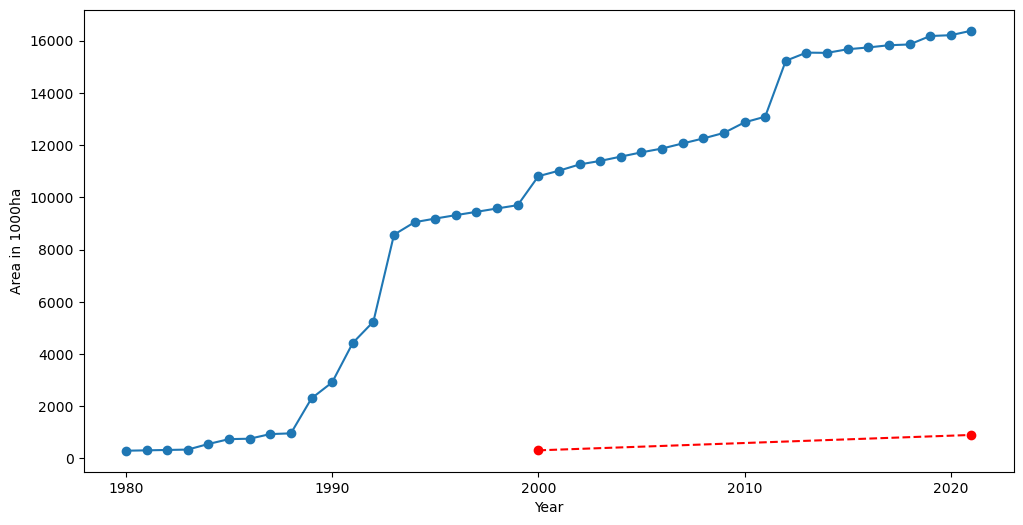

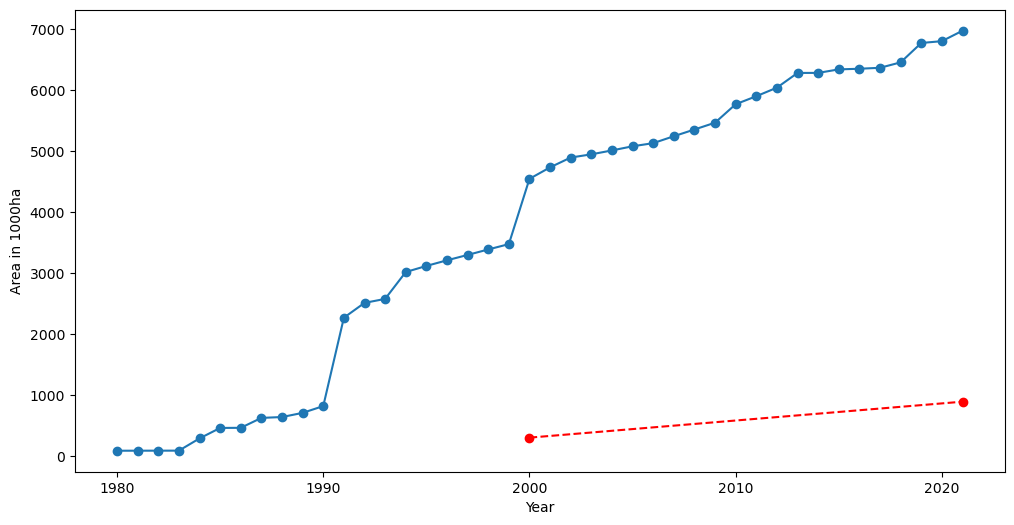

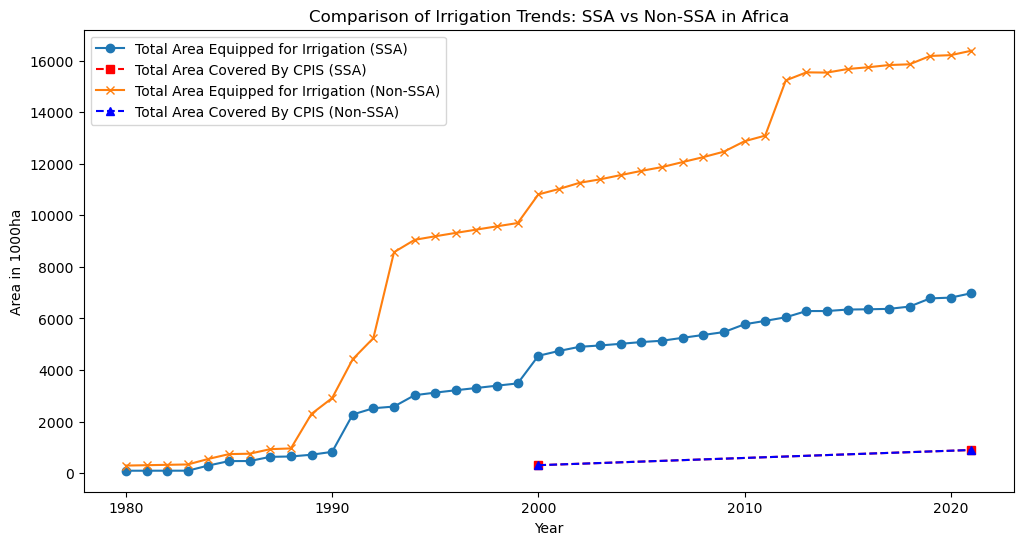

In [51]:
# Sum values in each year
AQUA_yearly = AQUAAll.groupby('Year')['Value'].sum().reset_index()
CPIS_sum = CPIS_SSA.groupby('Year')['Area_1000ha'].sum().reset_index()

AQUA_yearly_SSA = AQUAAll_SSA.groupby('Year')['Value'].sum().reset_index()
CPIS_sum_SSA = CPIS_SSA.groupby('Year')['Area_1000ha'].sum().reset_index()

plt.figure(figsize = (12,6))
plt.plot(AQUA_yearly['Year'], AQUA_yearly['Value'], label = 'Total Area Equipped for Irrigation', marker = 'o')

plt.scatter(CPIS_sum['Year'], CPIS_sum['Area_1000ha'], color = 'red', label = 'Total Area Covered By Center Pivot Irrigation Systems')

plt.plot(CPIS_sum['Year'], CPIS_sum['Area_1000ha'], 'r--')

plt.xlabel('Year')
plt.ylabel('Area in 1000ha')
plt.show()

plt.figure(figsize = (12,6))
plt.plot(AQUA_yearly_SSA['Year'], AQUA_yearly_SSA['Value'], label = 'Total Area Equipped for Irrigation', marker = 'o')

plt.scatter(CPIS_sum_SSA['Year'], CPIS_sum_SSA['Area_1000ha'], color = 'red', label = 'Total Area Covered By Center Pivot Irrigation Systems')

plt.plot(CPIS_sum_SSA['Year'], CPIS_sum_SSA['Area_1000ha'], 'r--')

plt.xlabel('Year')
plt.ylabel('Area in 1000ha')
plt.show()


plt.figure(figsize=(12, 6))

# Plot Total Area Equipped for Irrigation (SSA)
plt.plot(AQUA_yearly_SSA['Year'], AQUA_yearly_SSA['Value'], label='Total Area Equipped for Irrigation (SSA)', marker='o')

# Plot Total Area Covered by CPIS (SSA)
plt.plot(CPIS_sum_SSA['Year'], CPIS_sum_SSA['Area_1000ha'], 'r--', marker='s', label='Total Area Covered By CPIS (SSA)')

# Plot Total Area Equipped for Irrigation (Non-SSA)
plt.plot(AQUA_yearly['Year'], AQUA_yearly['Value'], label='Total Area Equipped for Irrigation (Non-SSA)', marker='x')

# Plot Total Area Covered by CPIS (Non-SSA)
plt.plot(CPIS_sum['Year'], CPIS_sum['Area_1000ha'], 'b--', marker='^', label='Total Area Covered By CPIS (Non-SSA)')

# Labels and Legend
plt.xlabel('Year')
plt.ylabel('Area in 1000ha')
plt.title('Comparison of Irrigation Trends: SSA vs Non-SSA in Africa')
plt.legend()
plt.show()

